In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
cd drive/My Drive/AlexNet

/content/drive/My Drive/AlexNet


## Loading the important Libraries

In [0]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from collections import defaultdict
from data.scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
from nltk import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Loading the contents

In [0]:
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()
body_inverse_index = {bodies[i]: i for i in range(len(bodies))}

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [9]:
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 10]
train_discuss = all_discuss[:len(all_discuss) * 9 // 10]
train_agree = all_agree[:len(all_agree) * 9 // 10]
train_disagree = all_disagree[:len(all_disagree) * 9 // 10]


val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

train_unrelated = all_unrelated[:len(all_unrelated) //100]
train_discuss = all_discuss[:len(all_discuss) //100]
train_agree = all_agree[:len(all_agree) //100]
train_disagree = all_disagree[:len(all_disagree) //100]


val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

val_unrelated = val_unrelated[len(val_unrelated) * 9 // 10:]
val_discuss = val_discuss[len(val_discuss) * 9 // 10:]
val_agree = val_agree[len(val_agree) * 9 // 10:]
val_disagree = val_disagree[len(val_disagree) * 9 // 10:]



print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
Train	 365 	 89 	 36 	 8
Valid.	 366 	 90 	 37 	 9


# Uniform distribution of Data

In [10]:
print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))
train_all = (train_unrelated + train_discuss + train_agree + train_disagree)

# each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
train_all = np.array(train_all)

val_all = val_unrelated + val_discuss + val_agree + val_disagree
random.Random(0).shuffle(val_all)
val_all = np.array(val_all)

print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)
print(np.count_nonzero(train_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(train_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(train_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(train_all[:, 2] == 'disagree'))
print(np.count_nonzero(val_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(val_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(val_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(val_all[:, 2] == 'disagree'))

Train	 365 	 89 	 36 	 8
Valid.	 366 	 90 	 37 	 9
Train (Total) (498, 3) 	Validation (Total) (502, 3)
365 	 89 	 36 	 8
366 	 90 	 37 	 9


In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Tokenise text
pattern = re.compile("[^a-zA-Z0-9 ]+")  # strip punctuation, symbols, etc.
stop_words = set(stopwords.words('english'))
def tokenise(text):
    text = pattern.sub('', text.replace('\n', ' ').replace('-', ' ').lower())
    text = [word for word in word_tokenize(text) if word not in stop_words]
    return text

for i in range(9):
    print(train_all[i, 0]);print('Tokenized form is ------>',tokenise(train_all[i, 0]))
    print()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Microsoft turns to robotic security guards to watch for trouble
Tokenized form is ------> ['microsoft', 'turns', 'robotic', 'security', 'guards', 'watch', 'trouble']

Luke Somers 'killed in failed rescue attempt in Yemen'
Tokenized form is ------> ['luke', 'somers', 'killed', 'failed', 'rescue', 'attempt', 'yemen']

Suspected meteorite leaves crater in Managua, is linked to asteroid
Tokenized form is ------> ['suspected', 'meteorite', 'leaves', 'crater', 'managua', 'linked', 'asteroid']

New Audio Shows Michael Brown Was Shot at 11 Times
Tokenized form is ------> ['new', 'audio', 'shows', 'michael', 'brown', 'shot', '11', 'times']

Saudi cleric condemns snowmen as anti-Islamic
Tokenized form is ------> ['saudi', 'cleric', 'condemns', 'snowmen', 'anti', 'islamic']

‘Te

In [13]:
# Compute term-frequency of words in documents
def doc_to_tf(text, ngram=1):
    words = tokenise(text)
    ret = defaultdict(float)
    for i in range(len(words)):
        for j in range(1, ngram+1):
            if i - j < 0:
                break
            word = [words[i-k] for k in range(j)]
            ret[word[0] if ngram == 1 else tuple(word)] += 1.0
    return ret
    
for i in range(5):
    print(train_all[i, 0]);print('Term frequency form is ------->',doc_to_tf(train_all[i, 0]))
    print()


Microsoft turns to robotic security guards to watch for trouble
Term frequency form is -------> defaultdict(<class 'float'>, {'turns': 1.0, 'robotic': 1.0, 'security': 1.0, 'guards': 1.0, 'watch': 1.0, 'trouble': 1.0})

Luke Somers 'killed in failed rescue attempt in Yemen'
Term frequency form is -------> defaultdict(<class 'float'>, {'somers': 1.0, 'killed': 1.0, 'failed': 1.0, 'rescue': 1.0, 'attempt': 1.0, 'yemen': 1.0})

Suspected meteorite leaves crater in Managua, is linked to asteroid
Term frequency form is -------> defaultdict(<class 'float'>, {'meteorite': 1.0, 'leaves': 1.0, 'crater': 1.0, 'managua': 1.0, 'linked': 1.0, 'asteroid': 1.0})

New Audio Shows Michael Brown Was Shot at 11 Times
Term frequency form is -------> defaultdict(<class 'float'>, {'audio': 1.0, 'shows': 1.0, 'michael': 1.0, 'brown': 1.0, 'shot': 1.0, '11': 1.0, 'times': 1.0})

Saudi cleric condemns snowmen as anti-Islamic
Term frequency form is -------> defaultdict(<class 'float'>, {'cleric': 1.0, 'condemns

In [14]:
print(train_all[0, 0]);print('Term frequency form is ------->',doc_to_tf(train_all[0, 0], ngram=2))

Microsoft turns to robotic security guards to watch for trouble
Term frequency form is -------> defaultdict(<class 'float'>, {('turns',): 1.0, ('robotic',): 1.0, ('robotic', 'turns'): 1.0, ('security',): 1.0, ('security', 'robotic'): 1.0, ('guards',): 1.0, ('guards', 'security'): 1.0, ('watch',): 1.0, ('watch', 'guards'): 1.0, ('trouble',): 1.0, ('trouble', 'watch'): 1.0})


In [15]:
# Build corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 44973 are bodies, 44974 to 89943 are headlines

print(corpus[44974//100])
print(corpus[0])

Crews removed a time capsule dating back to 1795 on Thursday from the granite cornerstone of the Massachusetts Statehouse, where historians believe it was originally placed by Revolutionary War luminaries Samuel Adams and Paul Revere among others.

The small time capsule is believed to contain items such as old coins, documents, newspapers and a metal plate that was owned by Revere.

Secretary of State William Galvin speculated that some of the items could have deteriorated over time.

Official plan to X-ray the capsule on Sunday at Boston's Museum of Fine Arts to get some idea of the contents and possibly details on their condition, then open it next week.

Scroll down for video

Pamela Hatchfield, a conservator at the Boston's Museum of Fine Arts, holds a time capsule she had just removed from the cornerstone of the Statehouse in Boston on Thursday

Originally made of cowhide, the time capsule was believed to have been embedded in the cornerstone when construction on the state Capito

In [16]:
# Learn idf of every word in the corpus
df = defaultdict(float)
for doc in tqdm(corpus):
    words = tokenise(doc)
    seen = set()
    for word in words:
        if word not in seen:
            df[word] += 1.0
            seen.add(word)

print(list(df.items())[:10])

100%|██████████| 996/996 [00:00<00:00, 1153.66it/s]

[('militants', 73.0), ('islamic', 125.0), ('state', 162.0), ('jihadi', 27.0), ('group', 121.0), ('released', 91.0), ('video', 168.0), ('appears', 67.0), ('show', 81.0), ('beheading', 37.0)]


In [17]:
num_docs = corpus.shape[0]
idf = defaultdict(float)
for word, val in tqdm(df.items()):
    idf[word] = np.log((1.0 + num_docs) / (1.0 + val)) + 1.0  # smoothed idf

print(list(idf.items())[:10])

100%|██████████| 12968/12968 [00:00<00:00, 469221.91it/s]

[('militants', 3.6006856767576685), ('islamic', 3.0684688630103603), ('state', 2.811000569155076), ('jihadi', 4.572546259786634), ('group', 3.100729725228582), ('released', 3.382962192912798), ('video', 2.7748520550387648), ('appears', 3.6852430647857317), ('show', 3.4980315226975853), ('beheading', 4.267164610235453)]


In [18]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))

print(glove_vectors['glove'])

400000it [00:07, 54436.70it/s]

[-1.2879   -0.14538  -0.016613  1.1387    1.1317    0.20705  -0.47351
  0.15898   0.67879   0.2382    0.11621   0.26053  -0.8379    1.1232
  0.31469  -0.47904  -0.33717  -0.34492  -0.72053  -1.0543   -0.58476
 -0.42184  -0.56977  -1.1697   -0.50389  -1.4706   -0.22005   1.1314
  1.0829   -1.5477    0.77931  -0.22865   0.33369   0.52067   0.22109
  1.1267    0.11704   1.1647    0.5875   -0.079243  0.022386  0.90118
 -0.37459   0.82637  -0.41061  -0.95039   0.44121  -0.58558   0.12594
 -0.71778 ]


In [19]:
# Convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf = doc_to_tf(doc)
    doc_tf_idf = defaultdict(float)
    for word, tf in doc_tf.items():
        doc_tf_idf[word] = tf * idf[word]
        
    doc_vector = np.zeros(glove_vectors['glove'].shape[0])
    if np.sum(list(doc_tf_idf.values())) == 0.0:  # edge case: document is empty
        return doc_vector
    
    for word, tf_idf in doc_tf_idf.items():
        if word in glove_vectors:
            doc_vector += glove_vectors[word] * tf_idf
    doc_vector /= np.sum(list(doc_tf_idf.values()))
    return doc_vector

for i in range(2):
    print(train_all[i, 0], doc_to_glove(train_all[i, 0]))

Microsoft turns to robotic security guards to watch for trouble [ 0.47790114 -0.26356462  0.42278357 -0.16127354  0.32795086 -0.16013121
 -0.12523431  0.08677343  0.22412232 -0.48682217 -0.04788016  0.05802041
 -0.34860754  0.67548565 -0.07826219  0.09165369 -0.19808928  0.26399418
 -0.40019942 -0.46243058  0.04996871  0.54784477 -0.100381   -0.05174086
  0.25679119 -1.3353036  -0.0625064   0.05865378  0.43568089 -0.25141575
  2.15771538  0.2654065  -0.32139962 -0.34443457  0.00312252  0.61979906
  0.02926048 -0.1369583  -0.18728404 -0.19697257 -0.14707441  0.16450667
  0.16975282  0.23117808  0.36940231 -0.335339    0.32558284 -0.19607958
 -0.0598006  -0.06635737]
Luke Somers 'killed in failed rescue attempt in Yemen' [ 0.88152154 -0.43893853  0.32753919 -0.22548821  0.06446299  0.12330746
 -0.50311872  0.59993137  0.38812034 -0.43566448 -0.13720048  0.01199305
 -0.24538776  0.11605388 -0.10012679  0.01099147  0.23862748 -0.20879648
 -0.57313285  0.47387832  0.131146    0.43542105  0.

In [20]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def dot_product(vec1, vec2):
    sigma = 0.0
    for i in range(vec1.shape[0]):  # assume vec1 and vec2 has same shape
        sigma += vec1[i] * vec2[i]
    return sigma
    
def magnitude(vec):
    return np.sqrt(np.sum(np.square(vec)))
        
def cosine_similarity(doc):
    headline_vector = doc_to_glove(doc[0])
    body_vector = doc_to_glove(doc[1])
    
    if magnitude(headline_vector) == 0.0 or magnitude(body_vector) == 0.0:  # edge case: document is empty
        return 0.0
    
    return dot_product(headline_vector, body_vector) / (magnitude(headline_vector) * magnitude(body_vector))

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])
print(cosine_similarity(train_all[27069//100]), tokenise(train_all[27069//100, 0]), tokenise(train_all[2706//100, 1]))  # edge case

0.8137865701733668 unrelated
0.7532816326838426 unrelated
0.33173190954409465 unrelated
0.8352286147270115 unrelated
0.37398171565369837 unrelated
0.5184086869423955 unrelated
0.6554583824710872 unrelated
0.6230114553139129 unrelated
0.8350342674237599 unrelated
0.8136639907989834 discuss
0.8837926082858903 ['apple', 'watch', 'launch', 'expected', 'late', 'march'] ['isaac', 'abrak', 'abuja', 'nov', '1', 'reuters', 'man', 'claiming', 'boko', 'haram', 'leader', 'abubakar', 'shekau', 'said', '200', 'girls', 'kidnapped', 'group', 'six', 'months', 'ago', 'married', 'fighters', 'contradicting', 'nigerian', 'government', 'claims', 'would', 'soon', 'freed', 'nigerias', 'military', 'says', 'killed', 'shekau', 'year', 'ago', 'authorities', 'said', 'september', 'also', 'killed', 'imposter', 'posting', 'videos', 'latest', 'recording', 'hard', 'see', 'mans', 'face', 'filmed', 'distance', 'likely', 'raise', 'grave', 'doubts', 'whether', 'talks', 'boko', 'haram', 'faction', 'government', 'neighboring

In [21]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
def divergence(lm1, lm2):
    sigma = 0.0
    for i in range(lm1.shape[0]):  # assume lm1 and lm2 has same shape
        sigma += lm1[i] * np.log(lm1[i] / lm2[i])
    return sigma

def kl_divergence(doc, eps=0.1):
    # Convert headline and body to 1-gram representations
    tf_headline = doc_to_tf(doc[0])
    tf_body = doc_to_tf(doc[1])
    
    # Convert dictionary tf representations to vectors (make sure columns match to the same word)
    words = set(tf_headline.keys()).union(set(tf_body.keys()))
    vec_headline, vec_body = np.zeros(len(words)), np.zeros(len(words))
    i = 0
    for word in words:
        vec_headline[i] += tf_headline[word]
        vec_body[i] = tf_body[word]
        i += 1
    
    # Compute a simple 1-gram language model of headline and body
    lm_headline = vec_headline + eps
    lm_headline /= np.sum(lm_headline)
    lm_body = vec_body + eps
    lm_body /= np.sum(lm_body)
    
    # Return KL-divergence of both language models
    return divergence(lm_headline, lm_body)

for i in range(10):
    # unrelated should have higher than rest
    print(kl_divergence(train_all[i]), train_all[i, 2])
print(kl_divergence(train_all[27069//100]), tokenise(train_all[27069//100, 0]), tokenise(train_all[27069//100, 1]))  # edge case

0.6383317660323755 unrelated
0.6767952871124852 unrelated
1.0724215077130463 unrelated
1.5593769535341642 unrelated
0.7546378167393307 unrelated
1.2363935240419581 unrelated
1.7195462848457004 unrelated
1.2264337627683246 unrelated
0.8785284976491702 unrelated
0.8708587703559143 discuss
0.7802656163135722 ['apple', 'watch', 'launch', 'expected', 'late', 'march'] ['tim', 'cook', 'unveiled', 'apple', 'watch', 'back', 'september', 'official', 'launch', 'date', 'set', 'oh', 'vague', 'spring', '2015', 'first', 'guess', 'launch', 'date', 'could', 'actually', 'look', 'like', '9to5mac', 'reports', 'apple', 'watch', 'set', 'ship', 'us', 'end', 'march', 'apple', 'store', 'retail', 'training', 'scheduled', 'mid', 'february', 'according', 'report', 'apple', 'sending', 'representatives', 'apple', 'stores', 'apples', 'offices', 'cupertino', 'austin', 'texas', 'learn', 'watch', 'better', 'prepare', 'store', 'employees', 'watch', 'arrives', 'addition', 'report', 'states', 'apple', 'finishing', 'work',

In [22]:
# Other feature 1
def ngram_overlap(doc):
    # Returns how many times n-grams (up to 3-gram) that occur in the article's headline occur on the article's body.
    tf_headline = doc_to_tf(doc[0], ngram=3)
    tf_body = doc_to_tf(doc[1], ngram=3)
    matches = 0.0
    for words in tf_headline.keys():
        if words in tf_body:
            matches += tf_body[words]
    return np.power((matches / len(tokenise(doc[1]))), 1 / np.e)  # normalise for document length

for i in range(10):
    # unrelated should have lower than rest
    print(ngram_overlap(train_all[i]), train_all[i, 2])

0.1275990374086362 unrelated
0.12665421624069553 unrelated
0.0 unrelated
0.0 unrelated
0.11857015285617747 unrelated
0.0 unrelated
0.0 unrelated
0.0 unrelated
0.11739876749926238 unrelated
0.36227527992391884 discuss


In [23]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence, ngram_overlap]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec

# Initialise X (matrix of feature vectors) for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:10])

100%|██████████| 498/498 [00:04<00:00, 110.03it/s]

[[0.81378657 0.63833177 0.12759904]
 [0.75328163 0.67679529 0.12665422]
 [0.33173191 1.07242151 0.        ]
 [0.83522861 1.55937695 0.        ]
 [0.37398172 0.75463782 0.11857015]
 [0.51840869 1.23639352 0.        ]
 [0.65545838 1.71954628 0.        ]
 [0.62301146 1.22643376 0.        ]
 [0.83503427 0.8785285  0.11739877]
 [0.81366399 0.87085877 0.36227528]]


In [24]:
# Define label <-> int mappings for y
label_to_int = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
int_to_label = ['agree', 'disagree', 'discuss', 'unrelated']

# Initialise Y (gold output vector) for train dataset
y_train = np.array([label_to_int[i] for i in train_all[:, 2]])
print(y_train[:10])

[3 3 3 3 3 3 3 3 3 2]


In [25]:
# Check integrity of X and Y
print(np.where(np.isnan(x_train)))
print(np.where(np.isfinite(x_train) == False))
print(x_train.shape)
print(y_train.shape)  # x_train.shape[0] == y_train.shape[0]

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(498, 3)
(498,)


[('g', 'agree'), ('r', 'disagree'), ('b', 'discuss'), ('y', 'unrelated')]


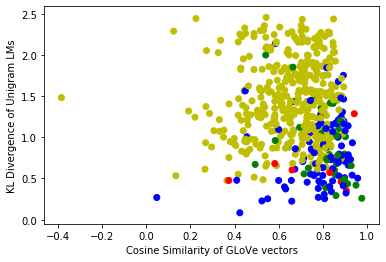

In [26]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['g', 'r', 'b', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], int_to_label[i]) for i in range(len(int_to_label))])
plt.show()

In [27]:
# Initialise x (feature vectors) for validation dataset
x_val = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_val[:5])

100%|██████████| 502/502 [00:04<00:00, 119.08it/s]

[[0.86310587 0.75480564 0.58394829]
 [0.79668325 0.8055688  0.54654326]
 [0.59693405 1.55700575 0.        ]
 [0.81172181 0.51905294 0.40749492]
 [0.92141186 0.40409695 0.41760117]]


In [28]:
# Linear regression model
def mse(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        sigma += np.square(pred[i] - gold[i])
    return sigma / (2 * pred.shape[0])

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))

0.04833333333333334


In [29]:
class LinearRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = intercept + x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        # self.intercept = 0.0
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            # Thetas
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # Intercept
            # s_int = 0.0
            # for row in range(X.shape[0]):
            #     s_int += (model_Y[row] - Y[row]) * 1.0
            # self.intercept -= self.lrn_rate * s_int / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'MSE:', mse(model_Y, Y))
        print('Final MSE:', mse(model_Y, Y))
        # print('Intercept:', self.intercept)
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            # s = self.intercept
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return Y
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
lr = LinearRegression(lrn_rate=0.1, n_iter=100)
lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
print(lr.transform(x_train[1000:1020]))
print('Predicted', lr.predict(x_train[1000:1020]))
print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

100%|██████████| 100/100 [00:00<00:00, 501.42it/s]

Final MSE: 0.06366272285209228
Model: [ 0.11742236  0.51819049 -0.3084639 ]
[]
Predicted []
Actual []


In [30]:
# Logistic regression functions
def sigmoid(Y):
    return 1 / (1 + np.exp(Y * -1))

print(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])))

def logistic_cost(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        if gold[i] == 1:  
            sigma -= np.log(pred[i])
        elif gold[i] == 0:
            sigma -= np.log(1 - pred[i])
    return sigma / pred.shape[0]

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])), np.array([0, 0, 0, 1, 1, 1])))

[0.5        0.549834   0.62245933 0.62245933 0.68997448 0.73105858]
0.04833333333333334
0.3054302439580517
0.6039670619612919


In [31]:
# Logistic regression model
class LogisticRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'loss:', logistic_cost(model_Y, Y))
        print('Final loss:', logistic_cost(model_Y, Y))
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return sigmoid(Y)
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
lr = LogisticRegression(lrn_rate=0.1, n_iter=100)
lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
print(lr.transform(x_train[1000:1020]))
print('Predicted', lr.predict(x_train[1000:1020]))
print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

100%|██████████| 100/100 [00:00<00:00, 479.67it/s]

Final loss: 0.4488180223240052
Model: [-0.11733909  1.08285356 -0.53298056]
[]
Predicted []
Actual []


In [32]:
# To use linear/logistic regression models to classify multiple classes
class OneVAllClassifier:
    
    def __init__(self, regression, **params):
        self.regression = regression
        self.params = params
        
    def fit(self, X, Y):
        # Learn a model for each parameter.
        self.categories = np.unique(Y)
        self.models = {}
        for cat in self.categories:
            ova_Y = np.array([(1 if i == cat else 0) for i in Y])
            model = self.regression(**self.params)
            model.fit(X, ova_Y)
            self.models[cat] = model
            print(int_to_label[cat])
    
    def predict(self, X):
        # Predicts each x for each different model learned, and returns the category related to the model with the highest score.
        vals = {}
        for cat, model in self.models.items():
            vals[cat] = model.transform(X)
        Y = np.zeros(X.shape[0], dtype=np.int)
        for row in range(X.shape[0]):
            max_val, max_cat = -math.inf, -math.inf
            for cat, val in vals.items():
                if val[row] > max_val:
                    max_val, max_cat = val[row], cat
            Y[row] = max_cat
        return Y
    
# Test only
ova = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=100)
ova.fit(x_train[:1000], y_train[:1000])
print('Predicted', ova.predict(x_train[1000:1020]))
print('Actual', y_train[1000:1020])

 53%|█████▎    | 53/100 [00:00<00:00, 525.48it/s]

Final MSE: 0.029829163087022555
Model: [ 0.13660122 -0.03730523  0.15806904]
agree
Final MSE: 0.007701788871269617
Model: [ 0.03517284 -0.01240033  0.03503788]
disagree


100%|██████████| 100/100 [00:00<00:00, 513.05it/s]


Final MSE: 0.05323395600292336
Model: [ 0.34864676 -0.10174794  0.3611176 ]
discuss
Final MSE: 0.06366272285209228
Model: [ 0.11742236  0.51819049 -0.3084639 ]
unrelated
Predicted []
Actual []


In [33]:
# Train the linear regression & One-V-All classifier models on the train set
clf = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=1000)
clf.fit(x_train, y_train)

 11%|█         | 106/1000 [00:00<00:01, 527.91it/s]

Final MSE: 0.028236135853118325
Model: [ 0.05582314 -0.02452746  0.45948888]
agree


  5%|▌         | 52/1000 [00:00<00:01, 518.02it/s]

Final MSE: 0.007639856495945301
Model: [ 0.02685467 -0.0130704   0.08990469]
disagree


  6%|▌         | 55/1000 [00:00<00:01, 549.39it/s]

Final MSE: 0.046152077219628856
Model: [ 0.22796673 -0.09579306  0.96902959]
discuss


100%|██████████| 1000/1000 [00:01<00:00, 528.68it/s]

Final MSE: 0.04563674511848664
Model: [ 0.6096291   0.37603972 -1.37369446]
unrelated


In [34]:
# Predict y for validation set
y_pred = clf.predict(x_val)
print(y_pred[:5])
predicted = np.array([int_to_label[i] for i in y_pred])
print(predicted[:5])
print(val_all[:, 2][:5])

[2 2 3 2 2]
['discuss' 'discuss' 'unrelated' 'discuss' 'discuss']
['discuss' 'agree' 'unrelated' 'discuss' 'discuss']


In [0]:
# Prepare validation dataset format for score_submission in scorer.py
body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

In [36]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on VALIDATION set:
test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    29     |     8     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     8     |     1     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    77     |    13     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     3     |    363    |
-------------------------------------------------------------
ACCURACY: 0.876

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||   227.5   ||   91.5    ||   177.0   ||



In [37]:
# Predict y for validation set using logistic regression instead of linear regression, and compare results of scorer.py
clf_logistic = OneVAllClassifier(LogisticRegression, lrn_rate=0.1, n_iter=1000)
clf_logistic.fit(x_train, y_train)

y_pred = clf_logistic.predict(x_val)
predicted = np.array([int_to_label[i] for i in y_pred])

body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print()
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))
# linear regression performs better, so that model is chosen for the test set

  5%|▌         | 53/1000 [00:00<00:01, 523.04it/s]

Final loss: 0.23117450537426434
Model: [-0.54408483 -2.09059431  0.86996037]
agree


  6%|▌         | 56/1000 [00:00<00:01, 555.65it/s]

Final loss: 0.07095698868086765
Model: [-1.59001281 -2.84971635 -0.22028186]
disagree


  5%|▍         | 48/1000 [00:00<00:02, 475.05it/s]

Final loss: 0.31588323711644284
Model: [ 0.75187571 -2.25989577  2.23512962]
discuss


100%|██████████| 1000/1000 [00:01<00:00, 514.29it/s]

Final loss: 0.27424774857999873
Model: [-1.70928736  2.51737516 -3.58069061]
unrelated

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    25     |    12     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     4     |     5     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    60     |    30     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     1     |    365    |
-------------------------------------------------------------
ACCURACY: 0.847

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||

In [0]:
# Load test data from CSV
f_tbodies = open('data/competition_test_bodies.csv', 'r', encoding='utf-8')
csv_tbodies = csv.DictReader(f_tbodies)
tbodies = []
for row in csv_tbodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(tbodies):
        tbodies += [None] * (body_id + 1 - len(tbodies))
    tbodies[body_id] = row['articleBody']
f_tbodies.close()
tbody_inverse_index = {tbodies[i]: i for i in range(len(tbodies))}

test_all = []  # each article = (headline, body, stance)

f_tstances = open('data/competition_test_stances.csv', 'r', encoding='utf-8')
csv_tstances = csv.DictReader(f_tstances)
for row in csv_tstances:
    body = tbodies[int(row['Body ID'])]
    test_all.append((row['Headline'], body, row['Stance']))
f_tstances.close()

#test_all = np.array(test_all)  # for some reason gives MemoryError
#print(test_all.shape)

In [39]:
# Initialise x (feature vectors) and y for test dataset
x_test = np.array([to_feature_array(doc) for doc in tqdm(test_all)])
print(x_test[:5])

100%|██████████| 25413/25413 [03:20<00:00, 126.82it/s]

[[0.81500471 1.84940367 0.        ]
 [0.59411954 1.50340396 0.        ]
 [0.70338783 1.32746514 0.14596078]
 [0.5879987  1.17096374 0.        ]
 [0.80604129 2.1493695  0.        ]]


In [40]:
# Predict y for test set
y_test = clf.predict(x_test)
print(y_pred[:5])
pred_test = np.array([int_to_label[i] for i in y_test])
print(pred_test[:5])

[2 2 3 2 2]
['unrelated' 'unrelated' 'unrelated' 'unrelated' 'unrelated']


In [0]:
# Prepare test dataset format for score_submission in scorer.py
test_body_ids = [str(tbody_inverse_index[test_all[i][1]]) for i in range(len(test_all))]
test_pred_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': pred_test[i]} for i in range(len(test_all))])
test_gold_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': test_all[i][2]} for i in range(len(test_all))])

In [42]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on TEST set:
test_score, cm = score_submission(test_gold_for_cm, test_pred_for_cm)
null_score, max_score = score_defaults(test_gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |   1448    |    455    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    408    |    289    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |   3313    |   1151    |
-------------------------------------------------------------
| unrelated |     1     |     0     |    148    |   18200   |
-------------------------------------------------------------
ACCURACY: 0.847

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  8327.0   ||



## Comparison Models

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier   
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelPropagation

classifiers=[
    
    (LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100.0, fit_intercept=True,
    intercept_scaling=10, class_weight=None, random_state=None, solver='newton-cg', max_iter=10,
    multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None),"Logistic Regression"),
    
    
    (KNeighborsClassifier(1),"K Nearest Classifier "),
    
    (SVC(C=50.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),'Support Vector Machine Classifier'),
    
    (QuadraticDiscriminantAnalysis(),'Qudratic Discriminant Analysis'),
    
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'Random Forest Classifier'),
    
    (AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=0.01,
                        algorithm='SAMME.R', random_state=None),'Adaboost Classifier'),
    (SGDClassifier(),'SGD Classifier'),
    
    (DecisionTreeClassifier(max_depth=5),'Decision Tree Classifier'),
    (xgboost.XGBClassifier(learning_rate=0.1),'XG Boost Classifier'),
    
    (LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, 
        store_covariance=False,tol=0.00001),'Linear Discriminant Analysis'),
     
    (GaussianNB(),'Gaussian Naive Bayes')

    #(MultinomialNB(alpha=.01),'Multinomial Naive Bayes')
]

In [68]:
score=[];names=[]

for model,name in classifiers:
    clf=model.fit(x_train,y_train)
    y_pred=clf.predict(x_val)
    predicted = np.array([int_to_label[i] for i in y_pred])
    body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
    pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
    gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])
    
    test_score, cm = score_submission(gold_for_cm, pred_for_cm)
    null_score, max_score = score_defaults(gold_for_cm)
    print('*'*20);names.append(name)
    print(name)
    score.append(print_confusion_matrix(cm));
    a=SCORE_REPORT.format(max_score, null_score, test_score)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


********************
Logistic Regression
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    34     |     3     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     8     |     1     |
-------------------------------------------------------------
|  discuss  |     1     |     0     |    84     |     5     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     5     |    361    |
-------------------------------------------------------------
ACCURACY: 0.886
********************
K Nearest Classifier 
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
----------------------------------------------------------

In [69]:
for i in range(len(score)):
    score[i]=score[i]*100
print(score)

[88.64541832669323, 83.46613545816733, 88.64541832669323, 87.84860557768924, 84.26294820717132, 87.05179282868527, 86.65338645418326, 85.4581673306773, 86.25498007968127, 88.44621513944223, 86.45418326693228]


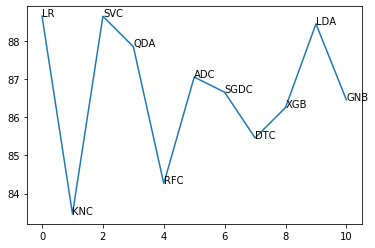

In [70]:
names=['LR','KNC','SVC','QDA','RFC','ADC','SGDC','DTC','XGB','LDA','GNB']
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
A = score[:]
plt.plot(A)
for i, label in enumerate(names):
    plt.text(i,A[i], label)
plt.show()